In [ ]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive  -o nonempty

In [ ]:
# #每次从这里开始执行
# import os 
# os.chdir("/Users/vinnton/Downloads/MNIST") #更改根目录


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import struct
import datetime
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#下面是预处理

In [3]:
def load_mnist(train_labels_path,train_images_path,test_labels_path,test_images_path):
    with open(train_labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        train_labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(train_images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        train_images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(train_labels), 784)
    with open(test_labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        test_labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(test_images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        test_images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(test_labels), 784)
    return  train_images, train_labels,test_images,test_labels
# >II 有两个部分:
# >: 这是指大端(用来定义字节是如何存储的))可查看维基 字节顺序
# I: 这是指一个无符号整数.

In [4]:
def VisualData(images,labels):
    fig, ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)#生成2行5列图标
    ax = ax.flatten()#2行5列变成1整行
    for i in range(10):
        img = images[labels == i][0].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [5]:

train_images, train_labels,test_images,test_labels=load_mnist('train-labels','train-images','test-labels','test-images')
# VisualData(test_images,test_labels)
#归一化
train_images=train_images.astype(np.float)
train_images=(train_images-127)/255
test_images=test_images.astype(np.float)
test_images=(test_images-127)/255

In [6]:
#下面是soft Max实现

In [7]:
def training(images,labels):
    labels=tf.one_hot(labels,10)#将label变成onehot向量
    TrainImage = tf.placeholder(tf.float32, shape=[None, 784])
    TrainLabel = tf.placeholder(tf.float32, shape=[None, 10])
    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))
    hypothsis = tf.nn.softmax(tf.matmul(TrainImage,W) + b)#输出的每一行表示一个image,第i行第j列表示第i个iamge代表数字j的概率（概率及对数字j的预测值除以所有预测值的和）
    hypothsis =hypothsis +1e-10
    #hypothsis =tf.clip_by_value(hypothsis,1e-8,tf.reduce_max(hypothsis))#避免预测值有0的出现，这样log就会出现NaN
    loss_cross_entropy = -tf.reduce_sum(TrainLabel*tf.log(hypothsis))
    Optimizer=tf.train.GradientDescentOptimizer(learning_rate=1e-6).minimize(loss_cross_entropy) 
    sess=tf.Session()
    sess.run(tf.initialize_all_variables())
    StartTime=datetime.datetime.now()
    for step in range(400000): 
        try:
            BatchImage=images[(step*50)%60000:(step*50+50)%60000]
            BatchLabel=labels.eval(session=sess)[(step*50)%60000:(step*50+50)%60000]
            Weight,bias,loss,_=sess.run([W,b,loss_cross_entropy,Optimizer], feed_dict={TrainImage:BatchImage, TrainLabel:BatchLabel}) 
            if step%2000==0:
                print("loss",loss)
        except KeyboardInterrupt:
            print("stop")
            break
    FinishTime=datetime.datetime.now()
    print("Time Cost:",(FinishTime-StartTime).total_seconds()/60, "minutes")
    return Weight,bias

In [8]:
def TestAccurancy(Weight,bias,test_labels,test_images):
  hypothsis=np.dot(test_images,Weight)+bias
  prediction = np.equal(np.argmax(hypothsis, 1), test_labels)
  accuracy = np.mean(prediction)
  return accuracy

In [9]:
Weight,bias=training(train_images,train_labels)
Accuracy=TestAccurancy(Weight,bias,test_labels,test_images)
print("Accuracy: ",Accuracy)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
loss 115.12927
stop
Time Cost: 0.0332803 minutes
Accuracy:  0.3531


In [10]:
#下面是CNN实现

In [11]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)#tf.truncated_normal(shape, mean, stddev) 正态分布:shape表示生成张量的维度，mean是均值，stddev是标准差。
  return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [22]:
def TrainConv(train_images,train_labels,test_images,test_labels):
    train_images=train_images.reshape(-1,28,28,1)
    train_labels=tf.one_hot(train_labels,10)#将label变成onehot向量
    test_images=test_images.reshape(-1,28,28,1)
    test_labels=tf.one_hot(test_labels,10)#将label变成onehot向量
    TrainImage = tf.placeholder(tf.float32, shape=[None, 28,28,1])
    TrainLabel = tf.placeholder(tf.float32, shape=[None, 10]) 
    #convolutional layer
    #第一层卷积
    W_conv1 = weight_variable([5, 5, 1, 32])#5*5大小 一个通道 32个卷积核
    b_conv1 = bias_variable([32])
    #第二层卷积
    W_conv2 = weight_variable([5, 5, 32, 64])#5*5大小 32个通道 64个卷积核 #第一层卷积得到32个feature map，可以看作32个通道；第二层是64个5*5的卷积核，每个卷积核有32个通道（每个卷积核都对输入的所有参数卷积）
    b_conv2 = bias_variable([64])
    #因为第二层有64个卷积核，所以对应64个bias
    h_conv1 = tf.nn.relu(conv2d(TrainImage, W_conv1) + b_conv1)#(1, 28, 28, 32) #b_conv1为32，每个卷积核对应一个bias
    h_pool1 = max_pool_2x2(h_conv1)#(1, 14, 14, 32)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)#(1, 7, 7, 64)
    #image[-1,28,28,1]表示图片尺寸是28*28，第四个参数1表示单通道
    #卷积核[5，5，1，32]表示卷积核尺寸是5*5，单通道，一共有32个卷积核
    #32个卷积核对一张图片进行卷积，步长为1，padding='SAME'（卷积边缘点时自动用0补全边缘）。
    #得到的结果是[1,28,28,32],表示每个feature map是28*28，一共32个feature map（因为有32个卷积核，每个卷积核卷积一整张图得到一个feature map）
    #bias为32，也就是每个卷积核对应一个bias，每个卷积核可以理解为提取一个特定的特征，，每个特定的特征有一个bias
    
    #Dense connect layer
    W_FullConect1=weight_variable([7 * 7 * 64, 1024])
    b_FullConect1=bias_variable([1024])
    W_FullConect2=weight_variable([1024, 10])
    b_FullConect2=bias_variable([10])
    h_pool2= tf.reshape(h_pool2,[-1,7 * 7 * 64])
    FullConnectLayer1=tf.nn.relu(tf.matmul(h_pool2, W_FullConect1)+b_FullConect1)
    keep_prob = tf.placeholder("float")    #drop out
    FullConnectLayer1Drop = tf.nn.dropout(FullConnectLayer1, keep_prob)#drop out
    hypothesis=tf.nn.softmax(tf.matmul(FullConnectLayer1Drop, W_FullConect2) + b_FullConect2)
    cross_entropy = -tf.reduce_sum(TrainLabel *tf.log(hypothesis))
    Optimizer = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    #预测正确率
    correct_prediction = tf.equal(tf.argmax(hypothesis,1), tf.argmax(TrainLabel,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    

    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    StartTime=datetime.datetime.now()
    ce = []
    for step in range(1000): 
        try:
            BatchImage=train_images[(step*50)%60000:(step*50+50)%60000]
            BatchLabel=train_labels.eval(session=sess)[(step*50)%60000:(step*50+50)%60000]
            A,C,_=sess.run([accuracy,cross_entropy,Optimizer], feed_dict={TrainImage:BatchImage, TrainLabel:BatchLabel, keep_prob:0.9}) 
            ce.append(C)
            if step%1000==0:
                print("accuracy",A)
                print("loss",C)
        except KeyboardInterrupt:
            print("stop")
            break
    FinishTime=datetime.datetime.now()
    print("Time Cost: ",(FinishTime-StartTime).total_seconds()/60,"minutes")
    print("Accuracy: ",sess.run([accuracy], feed_dict={TrainImage:test_images, TrainLabel:test_labels.eval(session=sess), keep_prob:0.9}) )
    return ce            

accuracy 0.14
loss 487.84305
Time Cost:  1.5640866666666668 minutes
Accuracy:  [0.9755]


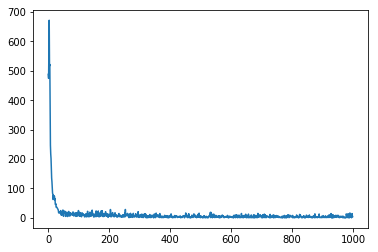

Text(0.5,1,'Loss')

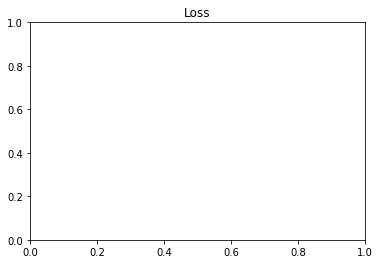

In [23]:
y = TrainConv(train_images, train_labels,test_images,test_labels)
x = range(1000)
plt.figure()
plt.plot(x,y)
plt.show()